Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lucid: A Quick Tutorial

This notebook quickly complete the tutorial notebook with further examples of objectives.

**Note**: The easiest way to use this tutorial is [as a colab notebook](https://colab.sandbox.google.com/github/tensorflow/lucid/blob/master/notebooks/tutorial.ipynb), which allows you to dive in with no setup. We recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

Thanks for trying Lucid!

<img src="https://storage.googleapis.com/lucid-static/common/stickers/channels-visualizations.jpg" width="600"></img>



## Install, Import, Load Model

In [2]:
# Install Lucid
# !pip install --quiet --upgrade-strategy=only-if-needed git+https://github.com/tensorflow/lucid.git

# %tensorflow_version only works on colab
# %tensorflow_version 1.x

In [2]:
# Imports

import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('1')

# uncomment to avoid deprecation warnings :
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
tf.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import lucid.modelzoo.vision_models as models
from lucid.misc.io import show
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import lucid.optvis.transform as transform

In [3]:
# Let's import a model from the Lucid modelzoo!

model = models.InceptionV1()

In this tutorial, we will be visualizing InceptionV1, also known as GoogLeNet.

While we will focus on a few neurons, you may wish to experiment with visualizing others. If you'd like, you can try any of the following layers: `conv2d0, maxpool0, conv2d1, conv2d2, maxpool1, mixed3a, mixed3b, maxpool4, mixed4a, mixed4b, mixed4c, mixed4d, mixed4e, maxpool10, mixed5a, mixed5b`.

You can learn more about GoogLeNet in the [paper](https://www.cs.unc.edu/~wliu/papers/GoogLeNet.pdf). You can also find visualizations of all neurons in mixed3a-mixed5b [here](https://distill.pub/2017/feature-visualization/appendix/).

#### Deep dream
Maximize "interestingness" of a given layer. See Mordvintsev et al., 2015.
The deep dream objective in Lucid maximizes the squared activation of every channels in the layer jointly.

512 93273.055



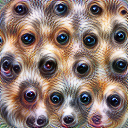

In [8]:
obj = objectives.deepdream("mixed4a")
_ = render.render_vis(model, obj)

Depending on the layer, the result of every channel optimized jointly may be more or less similar:

512 78209.99



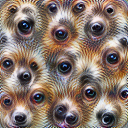

In [10]:
channel = lambda n: objectives.channel("mixed4a", n)
layer_depth = model.get_layer("mixed4a").depth
obj = sum([channel(k) for k in range(layer_depth)])
_ = render.render_vis(model, obj)

#### Logit visualisation
Just as we can visualize convolutional layers, it is possible to visualize what activates the most a logit of a given class.

To do that we have to set the dimensions of the image to the standard input size of the nerwork, (229\*229 for InceptionV1) because the default value is 128\*128 and produces dimension errors. Moreover, the set of transformations used for transformation robustness has to keep the dimensions constant.

By default, Lucid does 5 successive image transformation which can cause dimension errors. That's why we define a set of transformations that add at the end of these transformations a padding tp input dimensions to keep the dimensions constant.

In [17]:
param_funct = lambda: param.image(299)
transforms_set = [transformation for transformation in transform.standard_transforms]
transforms_set.append(transform.crop_or_pad_to(224,224))

Let's optimize the activation of logit 208 corresponding to the class Labrador retriever. See https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a for index-class mapping. 

As explained in https://distill.pub/2017/feature-visualization/, optimizing pre-softmax logits produces images of better visual quality than optimizing softmax directly. We can verify this by first optimizing the softmax layer then the pre-softmax layer.

512 0.9999856



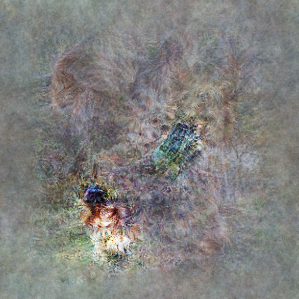

In [20]:
layer_name = "softmax2"
obj = objectives.class_logit(layer_name, 208) 
_ = render.render_vis(model, obj, param_funct, transforms=transforms_set)

512 174.55798



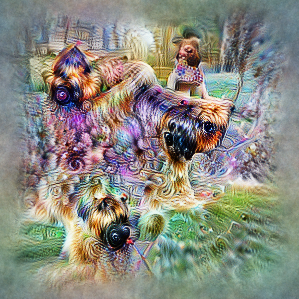

In [21]:
layer_name = "softmax2_pre_activation"
obj = objectives.class_logit(layer_name, 208) 
_ = render.render_vis(model, obj, param_funct, transforms=transforms_set)

We barely see something in the first image but in the second image we can distinguish dog hair and some snout.

### Directions
Let's consider that  each channel can be seen as a basis vector of an activation space. Therefore every possible linear combinations of channels represent a vector in this activation space. That's why we can also visualize a random direction in this activation space and not just basis vectors.

#### Direction objective
The direction objective visualize a layer along the given direction. 

Let $nb\_channels$ be the number of channels for the layer $layer\_name$ and $n$ a unit index in $[0,nb\_channels[$.
The method are equivalents for visualizing a single channel : 


512 822.14716



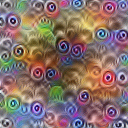

512 807.95703



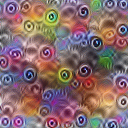

In [ ]:
layer_depth = model.get_layer("mixed4a").depth
channel_index = 18

# First method
obj_1 = objectives.direction("mixed4a", np.eye(layer_depth)[channel_index])
_ = render.render_vis(model, obj_1)

# Second method
obj_2 = objectives.channel("mixed4a", channel_index)
_ = render.render_vis(model, obj_2)

# Third method
_ = render.render_vis(model, "mixed4a:"+str(channel_index))